# Parallelization of overland flow and sediment transport simulation

Anna Petrasova  
2025-09-25

# Introduction

In this tutorial, we will model overland water flow as well as erosion
and deposition patterns along the Yadkin River in North Carolina, USA.
Subwatersheds that have larger erosion values are potentially the source
of increased sediment loads downstream, contributing to water quality
degradation and habitat disruption.

To simulate these processes, we will use the SIMWE model, with
simplified runoff inputs derived from the [National Land Cover Dataset
(NLCD)](https://www.mrlc.gov/data).

To enable parallel processing and improve computational efficiency, we
will divide the study area into hydrologic units ([HUC
12](https://www.usgs.gov/national-hydrography/access-national-hydrography-products)
subwatersheds, each approximately 100 km² in size) and run simulations
independently for each unit.

This approach demonstrates how to leverage new Python API features
introduced in GRASS 8.5—specifically, the [Tools
API](https://grass.osgeo.org/grass-devel/manuals/libpython/grass.tools.html#)
and the
[MaskManager](https://grass.osgeo.org/grass-devel/manuals/libpython/grass.script.html#grass.script.MaskManager)
and
[RegionManager](https://grass.osgeo.org/grass-devel/manuals/libpython/grass.script.html#grass.script.RegionManager)
context managers—which simplify region and mask handling and are
especially useful in parallel workflows.

The terrain data used for modeling will come from the [National
Elevation Dataset
(NED)](https://www.usgs.gov/publications/national-elevation-dataset) at
1/3 arc-second (~10 m) resolution.

Additional concepts covered in this tutorial:

-   Data download and ingestion
-   Creating GRASS projects
-   Data reprojection
-   Basic vector and raster data processing
-   Computational region
-   Using mask to mask out subwatershed area
-   Parallelization of a computational workflow
-   Overland water flow and sediment transport simulation

> **How to run this tutorial?**
>
> This tutorial is prepared to be run in a Jupyter notebook locally or
> using services such as Google Colab. You can [download the notebook
> here](SIMWE_parallelization.ipynb).
>
> If you are not sure how to get started with GRASS, checkout the
> tutorials [Get started with GRASS & Python in Jupyter
> Notebooks](../get_started/fast_track_grass_and_python.qmd) and [Get
> started with GRASS in Google
> Colab](../get_started/grass_gis_in_google_colab.qmd).

# Setup

Start with importing Python packages. To import the *grass* package, you
need to tell Python where the GRASS Python package is (can be skipped
for some environments).

In [1]:
# import standard Python packages
import os
import sys
import subprocess

sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)
# import GRASS Python packages
import grass.script as gs
import grass.jupyter as gj
from grass.tools import Tools

We will switch our working directory to a directory with enough space,
this is where we will download the datasets. With that, we will be able
to use shorter, relative paths.

In [2]:
os.chdir("path/to/data")

We will create a temporary folder, that will store our GRASS projects,
since we don’t need to retain them after we are done with the analysis.

In [3]:
import tempfile

tempdir = tempfile.TemporaryDirectory()
path = tempdir.name

# Input data download and processing

## Download and link NLCD data

Up-to-date download link to the NLCD data can be found at
[mrlc.gov/data](https://www.mrlc.gov/data). We will download and unzip
it to the current working directory.

In [4]:
import urllib.request
import zipfile
from pathlib import Path

url = "https://www.mrlc.gov/downloads/sciweb1/shared/mrlc/data-bundles/Annual_NLCD_LndCov_2024_CU_C1V1.zip"
nlcd_filename, headers = urllib.request.urlretrieve(url)
with zipfile.ZipFile(nlcd_filename, "r") as zip_ref:
    zip_ref.extractall()
os.remove(nlcd_filename)
nlcd_filename = Path(url).with_suffix(".tif").name

Create a GRASS project using the coordinate reference system (CRS) of
the NLCD dataset.

In [5]:
nlcd_project = Path(path, "nlcd")
# create a project
gs.create_project(nlcd_project, filename=nlcd_filename)
# initialize GRASS session in that project
session = gj.init(nlcd_project)

Link the NLCD raster with
[r.external](https://grass.osgeo.org/grass-devel/manuals/r.external.html).
This command creates a virtual raster without importing the full
dataset, allowing us to work with just the small sections needed from
the larger, nationwide NLCD file.

In [6]:
tools = Tools()
tools.r_external(input=nlcd_filename, output="nlcd")

We will use NLCD data later, now we process hydrography dataset.

## Download and process NC hydrography dataset

We will download and unzip [National Hydrography
Dataset](https://www.usgs.gov/national-hydrography/access-national-hydrography-products)
for North Carolina and create a GRASS project, in which we will extract
the river and adjacent subwatersheds.

In [7]:
url = "https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/NHD/State/GPKG/NHD_H_North_Carolina_State_GPKG.zip"
hydro_filename, headers = urllib.request.urlretrieve(url)
with zipfile.ZipFile(hydro_filename, "r") as zip_ref:
    zip_ref.extractall()
os.remove(hydro_filename)
hydro_filename = Path(url).with_suffix(".gpkg").name

We will create another project, called “hydro”, to do the initial
processing of the hydrography data in the original CRS of the data
(latitude-longitude CRS).

In [8]:
hydro_project = Path(path, "hydro")

gs.create_project(hydro_project, filename=hydro_filename)
session = gj.init(hydro_project)

First, let’s list the layers available:

In [9]:
print(tools.v_in_ogr(input=hydro_filename, flags="l").text)

``` text
NHDArea
NHDAreaEventFC
NHDFlowline
NHDLine
NHDLineEventFC
NHDPoint
NHDPointEventFC
NHDWaterbody
WBDHU10
WBDHU12
WBDHU14
WBDHU16
WBDHU2
WBDHU4
WBDHU6
WBDHU8
WBDLine
ExternalCrosswalk
NHDFCode
NHDFeatureToMetadata
NHDFlow
NHDFlowlineVAA
NHDMetadata
NHDProcessingParameters
NHDReachCodeMaintenance
NHDReachCrossReference
NHDSourceCitation
NHDStatus
NHDVerticalRelationship
```

Now we will import hydrography boundaries HUC12 (*WBDHU12*) to get the
subwatersheds and the flow lines (*NHDFlowline*) to extract the specific
river.

In [10]:
tools.v_in_ogr(input=hydro_filename, layer="WBDHU12")
tools.v_in_ogr(
    input=hydro_filename,
    layer="NHDFlowline",
    where="gnis_name == 'Yadkin River'",
    output="river",
)

Next, we want to extract the subwatersheds along the river. If we simply
overlap (with
[v.select](https://grass.osgeo.org/grass-devel/manuals/v.select.html))
the river and the subwatersheds, we will miss some of them because the
river data don’t always overlap or touch the subwatersheds.

In [11]:
tools.v_select(
    ainput="WBDHU12",
    binput="river",
    output="river_basins",
    operator="overlap",
)

basin_map = gj.InteractiveMap()
basin_map.add_vector("river_basins")
basin_map.add_vector("river")
basin_map.show()

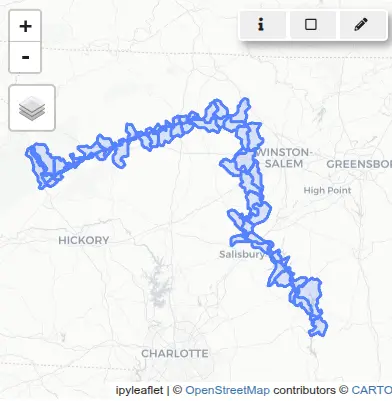

So instead we will
[buffer](https://grass.osgeo.org/grass-devel/manuals/v.buffer.html) the
river first:

In [12]:
tools.v_buffer(input="river", output="river_buffer", distance=0.01)
tools.v_select(
    ainput="WBDHU12",
    binput="river_buffer",
    output="river_basins",
    operator="overlap",
)

basin_map = gj.InteractiveMap()
basin_map.add_vector("river_basins")
basin_map.add_vector("river")
basin_map.show()

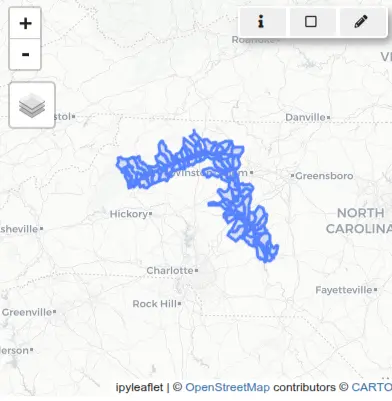

The rest of the workflow will be done in a CRS used in North Carolina
(EPSG 3358).

## Reprojecting vector data to a CRS used in North Carolina

Since we want our project to use a different CRS more suitable for our
study area (EPSG:3358 for North Carolina), we will create it now:

In [13]:
nc_project = path / "NC"
gs.create_project(nc_project, epsg="3358")
session = gj.init(nc_project)

We will reproject the river subwatersheds vector with
[v.proj]((https://grass.osgeo.org/grass-devel/manuals/v.proj.html)):

In [14]:
tools.v_proj(input="river_basins", project="hydro")

## Downloading NED elevation data

We will use GRASS addon
[r.in.usgs](https://grass.osgeo.org/grass-devel/manuals/addons/r.in.usgs.html)
to download and import NED layer using [USGS TNM Access
API](https://apps.nationalmap.gov/tnmaccess/).

In [15]:
tools.g_extension(extension="r.in.usgs")

First, we will set the computational region to match the river
subwatersheds and then list available datasets for that region (the
output at the time of creating this tutorial, it may vary later on):

In [16]:
tools.g_region(vector="river_basins")
print(
    tools.r_in_usgs(
        product="ned",
        ned_dataset="ned13sec",
        flags="i",
        output_directory=os.getcwd(),
    ).text
)

``` text
USGS file(s) to download:
-------------------------
Total download size:    5.32 GB
Tile count: 17
USGS SRS:   wgs84
USGS tile titles:
USGS 1/3 Arc Second n36w080 20240611
USGS 1/3 Arc Second n36w081 20240611
USGS 1/3 Arc Second n36w082 20220504
USGS 1/3 Arc Second n36w082 20220512
USGS 1/3 Arc Second n36w082 20240611
USGS 1/3 Arc Second n37w080 20210305
USGS 1/3 Arc Second n37w081 20210305
USGS 1/3 Arc Second n37w081 20240611
USGS 1/3 Arc Second n37w082 20210305
USGS 1/3 Arc Second n37w082 20220512
USGS 1/3 Arc Second n37w082 20240611
USGS 13 arc-second n36w080 1 x 1 degree
USGS 13 arc-second n36w081 1 x 1 degree
USGS 13 arc-second n36w082 1 x 1 degree
USGS 13 arc-second n37w080 1 x 1 degree
USGS 13 arc-second n37w081 1 x 1 degree
USGS 13 arc-second n37w082 1 x 1 degree
-------------------------
```

We will select the 2024 data and use the `title_filter` option to filter
them. We will download and import the datasets.

In [17]:
tools.r_in_usgs(
    product="ned",
    ned_dataset="ned13sec",
    output_directory=os.getcwd(),
    title_filter="20240611",
    output_name="ned",
)

Let’s now compute the erosion/deposition for one of the subwatersheds.

# Flow and erosion modeling for a single subwatershed

We begin our analysis by selecting a single HUC12 subwatershed from the
set of intersected basins. This subset will be used to test the erosion
and deposition simulation workflow. For all outputs, we will use unique
names with the subwatershed code as a prefix. That will help us with
parallelization later on.

Use
[v.db.select](https://grass.osgeo.org/grass-devel/manuals/v.db.select.html)
to retrieve the list of HUC12 codes from the attribute table that has
“areasqkm” and “huc12” attributes. Extract the smallest HUC12 polygon
using
[v.extract](https://grass.osgeo.org/grass-devel/manuals/v.extract.html).

In [18]:
# Select for example the smallest huc12
subwatersheds = tools.v_db_select(map="river_basins", format="json")["records"]
huc12 = min(subwatersheds, key=lambda x: x["areasqkm"])["huc12"]
tools.v_extract(
    input="river_basins",
    output=f"basin_{huc12}",
    where=f"huc12 == '{huc12}'",
    flags="t",
)

Set the computational region with
[g.region](https://grass.osgeo.org/grass-devel/manuals/g.region.html) to
match the bounds of the selected subwatershed.

In [19]:
tools.g_region(vector=f"basin_{huc12}")

Display the NED data for that region:

In [20]:
basin_map = gj.Map(current_region=True)
basin_map.d_rast(map="ned")
basin_map.d_vect(map=f"basin_{huc12}", fill_color="none")
basin_map.show()

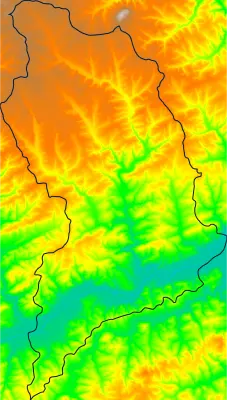

Set the region to match the extent of the basin and align resolution
with the elevation raster. Convert the selected vector to a raster using
[v.to.rast](https://grass.osgeo.org/grass-devel/manuals/v.to.rast.html).

In [21]:
tools.g_region(raster="ned", vector=f"basin_{huc12}")
tools.v_to_rast(input=f"basin_{huc12}", output=f"basin_{huc12}", use="val")

Apply a raster mask with
[MaskManager](https://grass.osgeo.org/grass-devel/manuals/libpython/grass.script.html#grass.script.MaskManager)
to restrict all subsequent raster operations to this subwatershed.
MaskManager is new in GRASS version 8.5. Alternatively, you can use
[r.mask](https://grass.osgeo.org/grass-devel/manuals/r.mask.html) to set
a mask.

In [22]:
mask = gs.MaskManager(mask_name=f"basin_{huc12}")
mask.activate()

basin_map = gj.Map(current_region=True)
basin_map.d_rast(map="ned")
basin_map.d_legend(
    raster="ned",
    flags="t",
    at=[10, 15, 40, 95],
    title="Elevation [m]",
    fontsize=12,
)
basin_map.show()

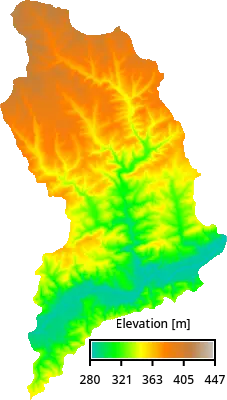

Reproject NLCD from a “nlcd” project to this project (see [NLCD
legend](https://www.usgs.gov/media/images/annual-nlcd-land-cover-change-legend)):

In [23]:
tools.r_proj(project="nlcd", mapset="PERMANENT", input="nlcd", output=f"nlcd_{huc12}")

basin_map = gj.Map()
basin_map.d_rast(map=f"nlcd_{huc12}")
basin_map.show()

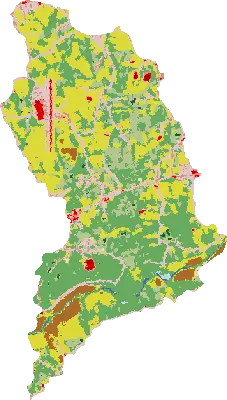

We will create a file `mannings.txt` to reclassify NLCD to manning’s
coefficients. The values are suggestions from the
[r.sim.water](https://grass.osgeo.org/grass-devel/manuals/r.sim.water.html)
documentation. The format is described in
[r.recode](https://grass.osgeo.org/grass-devel/manuals/r.recode.html)
documentation.

``` text
%%writefile mannings.txt
11:11:0.001
21:21:0.0404
22:23:0.0678
24:24:0.0404
31:31:0.0113
41:41:0.36
42:42:0.32
43:52:0.4
52:52:0.4
71:71:0.368
81:82:0.325
90:90:0.086
95:95:0.1825
```

In [24]:
tools.r_recode(input=f"nlcd_{huc12}", output=f"mannings_{huc12}", rules="mannings.txt")

Similarly, we will reclassify rainfall excess (rainfall minus
infiltration). These rainfall excess values were derived using the SCS
Curve Number method for 50 mm/h of precipitation, assigning typical
Curve Numbers based on common hydrologic soil groups for each NLCD land
cover class; they provide a rough estimate and should be refined with
local soil and land management data when available.

``` text
%%writefile runoff.txt
11:11:0.0
21:21:3.3     # Developed Open Space (CN ~68, HSG B)
22:22:7.9     # Developed Low Intensity (CN ~81, HSG C)
23:23:19.8    # Developed Medium Intensity (CN ~90, HSG C)
24:24:27.9    # Developed High Intensity (CN ~94, HSG D)
31:31:6.1     # Barren (CN ~75, HSG B)
41:41:0.0     # Forest (CN ~55, HSG A) — P < 0.2S → Q = 0
42:42:0.0
43:43:0.0
52:52:3.3     # Shrub/Scrub (CN ~68, HSG B)
71:71:2.0     # Grassland (CN ~61, HSG A)
81:81:5.1     # Pasture (CN ~74, HSG B)
82:82:14.7    # Cropland (CN ~82, HSG C)
90:90:0.0     # Woody Wetlands (CN ~70, HSG D) — often saturated, still low Q here
95:95:0.0     # Herbaceous Wetlands
```

In [25]:
tools.r_recode(input=f"nlcd_{huc12}", output=f"runoff_{huc12}", rules="runoff.txt")

Then, compute slope components (dx and dy) from the elevation raster to
support hydrologic modeling.

In [26]:
tools.r_slope_aspect(elevation="ned", dx=f"dx_{huc12}", dy=f"dy_{huc12}")

Run hydrologic and sediment simulations for the selected subwatershed.
First, simulate overland flow using
[r.sim.water](https://grass.osgeo.org/grass-devel/manuals/r.sim.water.html)
with inputs for topography, Manning’s coefficients, and rainfall
intensity. Running the simulation may take a while.

In [27]:
simulation_time = 180
tools.r_sim_water(
    elevation="ned",
    dx=f"dx_{huc12}",
    dy=f"dy_{huc12}",
    depth=f"depth_{huc12}",
    niterations=simulation_time,
    man=f"mannings_{huc12}",
    rain=f"runoff_{huc12}",
)

basin_map = gj.Map()
basin_map.d_rast(map=f"depth_{huc12}")
basin_map.d_legend(
    raster=f"depth_{huc12}",
    flags="t",
    at=[10, 15, 40, 95],
    title="Depth [m]",
    fontsize=12,
)
basin_map.show()

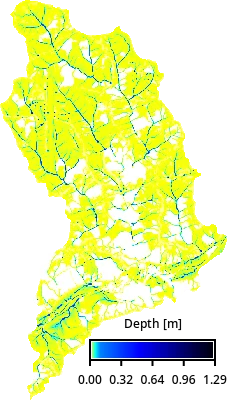

Then, define parameters for sediment transport and run
[r.sim.sediment](https://grass.osgeo.org/grass-devel/manuals/r.sim.sediment.html)
to compute erosion and deposition patterns. We will trim the resulting
raster’s edges to avoid extreme values at the edge. The additional
parameters for sediment erosion modeling are based on
[WEPP](https://www.ars.usda.gov/midwest-area/west-lafayette-in/national-soil-erosion-research/docs/wepp/research/)
model, here we use just a single-value estimate.

In [28]:
tools.r_mapcalc(expression=f"transport_capacity_{huc12} = 0.001")
tools.r_mapcalc(expression=f"detachment_coef_{huc12} = 0.001")
tools.r_mapcalc(expression=f"shear_stress_{huc12} = 0.01")
tools.r_sim_sediment(
    elevation="ned",
    water_depth=f"depth_{huc12}",
    dx=f"dx_{huc12}",
    dy=f"dy_{huc12}",
    detachment_coeff=f"detachment_coef_{huc12}",
    transport_coeff=f"transport_capacity_{huc12}",
    shear_stress=f"shear_stress_{huc12}",
    niterations=simulation_time,
    erosion_deposition=f"erdep_tmp_{huc12}",
    nwalkers=5 * gs.region()["cells"],
)
tools.r_grow(input=f"erdep_tmp_{huc12}", output=f"erdep_{huc12}", radius=-2.01)

basin_map = gj.Map()
basin_map.d_rast(map=f"erdep_{huc12}")
basin_map.d_legend(
    raster=f"erdep_{huc12}",
    flags="t",
    at=[10, 15, 40, 95],
    range=[-0.5, 0.5],
    digits=2,
    title="Erosion/dep. [kg/m2s]",
    fontsize=12,
)
basin_map.show()

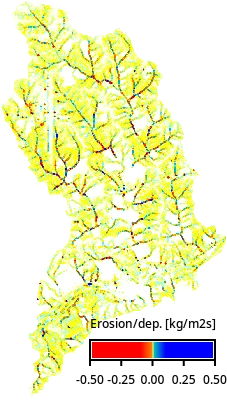

Calculate total erosion for the subwatershed. Negative values from
[r.sim.sediment](https://grass.osgeo.org/grass-devel/manuals/r.sim.sediment.html)
output are treated as erosion and converted to sediment mass. Summary
statistics are computed using
[r.univar](https://grass.osgeo.org/grass-devel/manuals/r.univar.html).

In [29]:
# Erosion: extract negative values and convert to positive mass [kg/m^2]
tools.r_mapcalc(
    f"erosion_{huc12} = if(erdep_{huc12} < 0, abs(erdep_{huc12}) * {simulation_time * 60}, null())"
)
erosion = tools.r_univar(map=f"erosion_{huc12}", format="json")
print(erosion["mean"])

Deactivate the active raster mask, restoring operations to apply across
the full computational region.

In [30]:
mask.deactivate()

Display water depth (`depth`) and erosion-deposition (`erdep`) rasters
for the selected subwatershed.

In [31]:
basin_map = gj.InteractiveMap()
basin_map.add_raster(f"depth_{huc12}")
basin_map.add_raster(f"erdep_{huc12}")
basin_map.show()

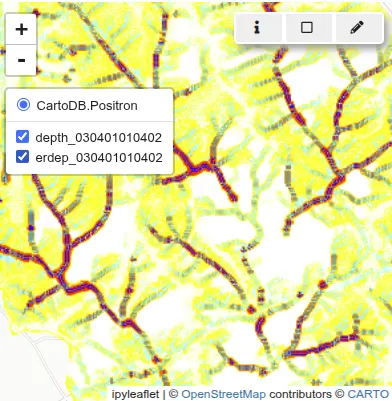

# Parallelized hydrologic and sediment modeling

To efficiently model erosion and deposition across a large number of
HUC12 subwatersheds, we will use the workflow we just ran and create a
script that uses Python’s `multiprocessing` module to parallelize the
workflow. Each subwatershed is processed independently in its own
environment, which allows computations to run concurrently without
interference.

Each subwatershed needs to set different computational region and mask.
However those setting are usually global for each mapset. So, to use
different regions and masks for each parallel process, we will use the
region and mask context managers.

-   Computational region is handled using `RegionManager`, a [context
    manager for setting and managing computational
    region](https://grass.osgeo.org/grass-devel/manuals/libpython/grass.script.html#grass.script.RegionManager),
    making it possible to have custom region for the current process.
    This feature is available only since GRASS 8.5.

    ``` python
    with gs.RegionManager(vector=f"basin_{huc12}"):
        # Run actual computation in the specified region.
        tools.r_sim_water(...)
    ```

-   Masking is handled using `MaskManager`, a [context manager for
    setting and managing raster
    mask](https://grass.osgeo.org/grass-devel/manuals/libpython/grass.script.html#grass.script.MaskManager),
    making it possible to have custom mask for the current process. This
    feature is available only since GRASS 8.5.

    ``` python
    with gs.MaskManager(mask_name=f"basin_{huc12}"):
        # Run actual computation with active mask.
        tools.r_sim_water(...)
    ```

## Putting it all together

We will put all the pieces together into a script that runs each
subwatershed in parallel. The resulting statistics for each subwatershed
are collected and stored in a JSON file for further analysis.

In [32]:
%%writefile script.py
import os
import json
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

import grass.script as gs
from grass.tools import Tools


def compute(huc12):
    simulation_time = 180
    # set overwrite to True to rerun the workflow
    tools = Tools(overwrite=True, quiet=True)
    tools.v_extract(
        input="river_basins",
        output=f"basin_{huc12}",
        where=f"huc12 == '{huc12}'",
        flags="t",
    )
    # Set the computational region to match the basin
    # while using the NED raster cell size and alignment
    with gs.RegionManager(vector=f"basin_{huc12}", raster="ned"):
        tools.v_to_rast(
            input=f"basin_{huc12}",
            output=f"basin_{huc12}",
            use="val",
        )
        tools.r_proj(
            project="nlcd",
            mapset="PERMANENT",
            input="nlcd",
            output=f"nlcd_{huc12}",
        )
        tools.r_recode(
            input=f"nlcd_{huc12}",
            output=f"mannings_{huc12}",
            rules="mannings.txt",
        )
        tools.r_recode(
            input=f"nlcd_{huc12}",
            output=f"runoff_{huc12}",
            rules="runoff.txt",
        )
        with gs.MaskManager(mask_name=f"basin_{huc12}"):
            # Run actual computation with active mask.
            tools.r_recode(
                input=f"nlcd_{huc12}",
                output=f"mannings_{huc12}",
                rules="mannings.txt",
            )
            tools.r_recode(
                input=f"nlcd_{huc12}",
                output=f"runoff_{huc12}",
                rules="runoff.txt",
            )
            tools.r_slope_aspect(
                elevation="ned",
                dx=f"dx_{huc12}",
                dy=f"dy_{huc12}",
            )
            tools.r_sim_water(
                elevation="ned",
                dx=f"dx_{huc12}",
                dy=f"dy_{huc12}",
                depth=f"depth_{huc12}",
                niterations=simulation_time,
                man=f"mannings_{huc12}",
                rain=f"runoff_{huc12}",
            )
            tools.r_mapcalc(expression=f"transport_capacity_{huc12} = 0.001")
            tools.r_mapcalc(expression=f"detachment_coef_{huc12} = 0.001")
            tools.r_mapcalc(expression=f"shear_stress_{huc12} = 0.01")
            region = tools.g_region(flags="p", format="json")
            tools.r_sim_sediment(
                elevation="ned",
                water_depth=f"depth_{huc12}",
                dx=f"dx_{huc12}",
                dy=f"dy_{huc12}",
                detachment_coeff=f"detachment_coef_{huc12}",
                transport_coeff=f"transport_capacity_{huc12}",
                shear_stress=f"shear_stress_{huc12}",
                niterations=simulation_time,
                erosion_deposition=f"erdep_tmp_{huc12}",
                nwalkers=5 * region["cells"],
            )
            tools.r_grow(
                input=f"erdep_tmp_{huc12}",
                output=f"erdep_{huc12}",
                radius=-2.01,
            )
            # Erosion: extract negative values and convert to positive mass [kg/m^2]
            tools.r_mapcalc(
                expression=f"erosion_{huc12} = if(erdep_{huc12} < 0, abs(erdep_{huc12}) * {simulation_time * 60}, 0)",
            )
            erosion = tools.r_univar(map=f"erosion_{huc12}", format="json", flags="e")
            return {
                "huc12": huc12,
                "erosion_mean": erosion["mean"],
                "erosion_median": erosion["median"],
                "erosion_total": erosion["sum"] * region["nsres"] * region["ewres"],
            }


if __name__ == "__main__":
    tools = Tools()
    # The entire workflow will run in parallel,
    # so this limits the number of threads each individual tool can use to 1.
    tools.g_gisenv(set="NPROCS=1")
    basins = tools.v_db_select(format="json", map="river_basins")["records"]
    huc12s = [basin["huc12"] for basin in basins]
    # set the number of processes to be used for the computation in total
    with Pool(processes=cpu_count()) as pool:
        result = list(tqdm(pool.imap(compute, huc12s), total=len(huc12s)))
        with open("result.json", "w") as fp:
            json.dump(result, fp)

Now execute the script, it will take some time.

In [33]:
%run script.py

Load the resulting JSON file into a pandas dataframe and normalize the
results, so that we can easily compare the subwatersheds.

In [34]:
import pandas as pd
import json

with open("result.json") as f:
    stats = json.load(f)

df = pd.DataFrame(stats)
df["normalized_erosion"] = df.erosion_mean / max(df.erosion_mean)
df

Load the subwatershed layers into geopandas for visualization. Join the
dataframe with the simulation values using the *huc12* key and from all
NC subwatersheds filter only those we initially selected that have now
computed erosion values.

In [35]:
import geopandas as gpd

gdf = gpd.read_file(hydro_filename, layer="WBDHU12")
gdf = gdf.merge(df, on="huc12", how="left")
# drop loaddate column because it's timestamp type
# not supported by JSON, would later fail
gdf = gdf.drop(columns=["loaddate"])
# keep only subwatersheds with computed values
gdf = gdf[gdf["erosion_total"].notna()]

Let’s visualize the data with folium:

In [36]:
import folium
import branca.colormap as cm

metric = "normalized_erosion"
color_scale = cm.linear.OrRd_09.scale(min(gdf[metric]), max(gdf[metric]))
color_scale.caption = "Min-max normalized mean erosion"
# get region center as latitude, longitude
region = tools.g_region(vector="river_basins", format="json", flags="b")
m = folium.Map(location=[region["ll_clat"], region["ll_clon"]], zoom_start=9)

tooltip = folium.GeoJsonTooltip(
    fields=["huc12", metric],
    aliases=["HUC12", "Normalized mean erosion:"],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
    max_width=800,
)

g = folium.GeoJson(
    gdf,
    style_function=lambda x: {
        "fillColor": color_scale(x["properties"][metric]),
        "color": "black", "weight": 1,
        "fillOpacity": 0.5,
    },
    tooltip=tooltip,
).add_to(m)
color_scale.add_to(m)
folium.LayerControl().add_to(m)
m

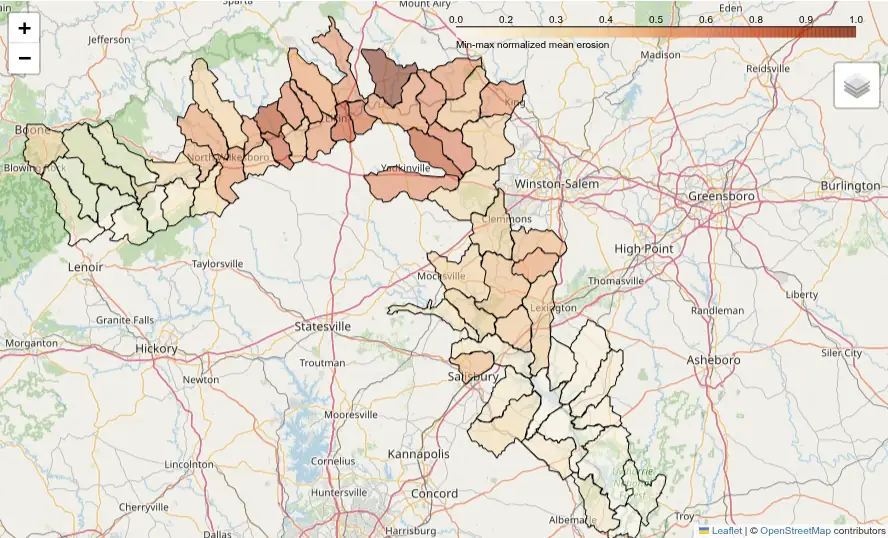

We can now identify subwatersheds that have larger erosion values and
are potentially the source of increased sediment loads downstream,
contributing to water quality degradation and habitat disruption.

## Acknowledgements

The development of this tutorial was supported by NSF Award #2322073,
granted to Natrx, Inc. and USDA NRCS award NR233A750023C043.